# SCEPTR Vector Alignment

This notebook examines the alignment among the scoring layer weight vectors and classifying layer weight vectors for multiple runs. Specifically:

1. Gather the best epoch for each run.
2. For each run, loads the model checkpoint and extracts:
   - `scoring_linear1.weight` (shape `[1,64]`)
   - `classifying_linear1.weight` (shape `[1,64]`)
3. Compares them using angles (cosine similarity) within each run (scoring vs classifying), and across runs (e.g. run i vs run j).

In [16]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import math
from pathlib import Path
import matplotlib.pyplot as plt

from src.model import load_trained, sceptr_unidirectional

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["figure.autolayout"] = True

import warnings
warnings.simplefilter("ignore")

## 1. Configuration
Adjust the `runs` dictionary so it maps each run index (0..9) to the best epoch. Then we’ll load each run’s checkpoint from `results-new-beta/sceptr/`.


In [17]:
bestepochs_alpha = {
    0: 49,
    1: 27,
    2: 16,
    3: 11,
    4: 43,
    5: 15,
    6: 35,
    7: 49,
    8: 15,
    9: 20,
}

bestepochs_beta = {
    0: 33,
    1: 49,
    2: 32,
    3: 20,
    4: 49,
    5: 10,
    6: 49,
    7: 43,
    8: 49,
    9: 49,
}

# comment/uncomment either alpha or beta to use it
runs = bestepochs_alpha
base_dir = Path.cwd() / "results-new-alpha" / "sceptr"

# runs = bestepochs_beta
# base_dir = Path.cwd() / "results-new-beta" / "sceptr"

model_dict = {}

for run_idx, best_epoch in runs.items():
    model_path = base_dir / f"trained-sceptr-{run_idx}" / f"Epoch {best_epoch}" / f"classifier-{best_epoch}.pth"
    model = load_trained(model_path, sceptr_unidirectional)
    model.eval()
    model_dict[run_idx] = model
    # print(f"Loaded run={run_idx}, epoch={best_epoch}: {model_path}")

## 2. Compare Scoring vs Classifying Weight Vector (Within Each Run)
For each run, compute:
- Cosine similarity between `scoring_linear1.weight` and `classifying_linear1.weight`
- The angle in degrees


In [18]:
import math

run_scoring_classifying = {}

for run_idx, mdl in model_dict.items():
    w_scoring = mdl.scoring_linear1.weight.detach().cpu().numpy()[0]
    w_class   = mdl.classifying_linear1.weight.detach().cpu().numpy()[0]

    # normalise
    w_scoring_n = w_scoring / (np.linalg.norm(w_scoring) + 1e-9)
    w_class_n   = w_class / (np.linalg.norm(w_class) + 1e-9)

    cos_sim = np.dot(w_scoring_n, w_class_n)
    angle   = math.degrees(math.acos(max(min(cos_sim,1),-1)))

    run_scoring_classifying[run_idx] = {
        'cosine_sim': cos_sim,
        'angle_deg': angle
    }

# display
df_sc_class = pd.DataFrame(run_scoring_classifying).T
df_sc_class.index.name = 'run'
df_sc_class

,cosine_sim,angle_deg
run,,
0,0.070353,85.965742
1,0.007424,89.574636
2,-0.059652,93.419824
3,-0.181413,100.452080
4,0.133731,82.314732
5,-0.042942,92.461171
6,0.011301,89.352504
7,0.095515,84.519048
8,0.188767,79.119146


## 3. Compare Scoring Vectors Across Runs
Produce a matrix `[num_runs, num_runs]` of pairwise cosine similarities for the scoring layer. Then the same for the classifying layer.


In [19]:
run_indices = sorted(list(model_dict.keys()))
n_runs = len(run_indices)

score_mat = np.zeros((n_runs, n_runs))
class_mat = np.zeros((n_runs, n_runs))

score_vectors = []  # shape [n_runs, 64]
class_vectors = []  # shape [n_runs, 64]

for r in run_indices:
    w_s = model_dict[r].scoring_linear1.weight.detach().cpu().numpy()[0]
    w_s /= (np.linalg.norm(w_s) + 1e-9)
    score_vectors.append(w_s)

    w_c = model_dict[r].classifying_linear1.weight.detach().cpu().numpy()[0]
    w_c /= (np.linalg.norm(w_c) + 1e-9)
    class_vectors.append(w_c)

score_vectors = np.array(score_vectors)
class_vectors = np.array(class_vectors)

for i in range(n_runs):
    for j in range(n_runs):
        # dot product for scoring layer
        sc_cos = np.dot(score_vectors[i], score_vectors[j])
        score_mat[i,j] = sc_cos

        # dot product for classifying layer
        cl_cos = np.dot(class_vectors[i], class_vectors[j])
        class_mat[i,j] = cl_cos

### 3.1: Visualise Cosine Similarity Matrices
Plot them as heatmaps. Values close to 1 mean the vectors are strongly aligned; negative means opposite directions.


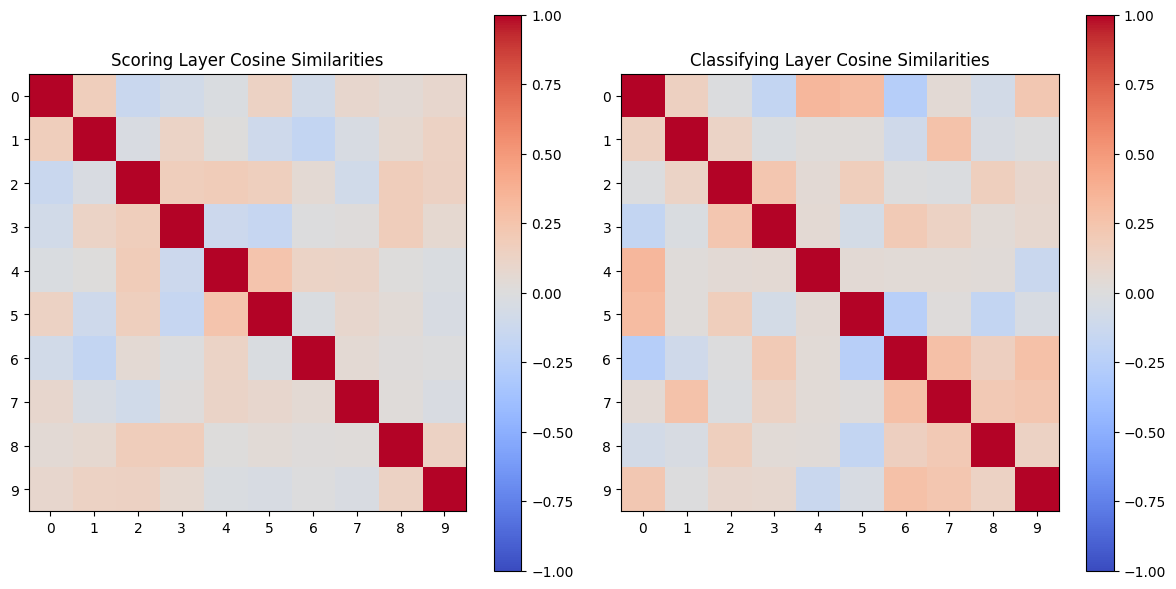

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
im0 = axs[0].imshow(score_mat, cmap="coolwarm", vmin=-1, vmax=1)
axs[0].set_title("Scoring Layer Cosine Similarities")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(class_mat, cmap="coolwarm", vmin=-1, vmax=1)
axs[1].set_title("Classifying Layer Cosine Similarities")
plt.colorbar(im1, ax=axs[1])

for ax in axs:
    ax.set_xticks(range(n_runs))
    ax.set_xticklabels(run_indices)
    ax.set_yticks(range(n_runs))
    ax.set_yticklabels(run_indices)

plt.show()